
# WeightWatcher - VGG

https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96


VGG is one of the first, large scale modern architectures based on the classic convolutional model of LeCun ,, resembling a larger scale version of LeNet5.  While there are earlier models (AlexNet, etc), VGG is usefukl because:

-  There are several variants, with 11, 13, 16, and 19 layers, and with and wthout Batch Normalization
-  It is widely available in pyTorch and other frameworks
-  There are versions trained on all of ImageNet, ImageNet-1K (a smaller data set), etc.
-  Although large,  is still used in Transfer Learning.

The general VGG series architecture consists of 

-  Several sets of Conv2D+ReLU layers (followed by Max Pooling), with feature maps increasing in size
-  3 final Fully Connected (Dense/Linear) layers

Below we show the VGG16 architecture, consisting of 16 layers.

The VGG series are considered very large models, with an enormous number of parameters comparexd to later models like ResNet and DenseNet series.  Most notably, compared to later models,

-  VGG models contain large, FC layers at the end
-  VGG does not contain residual connections


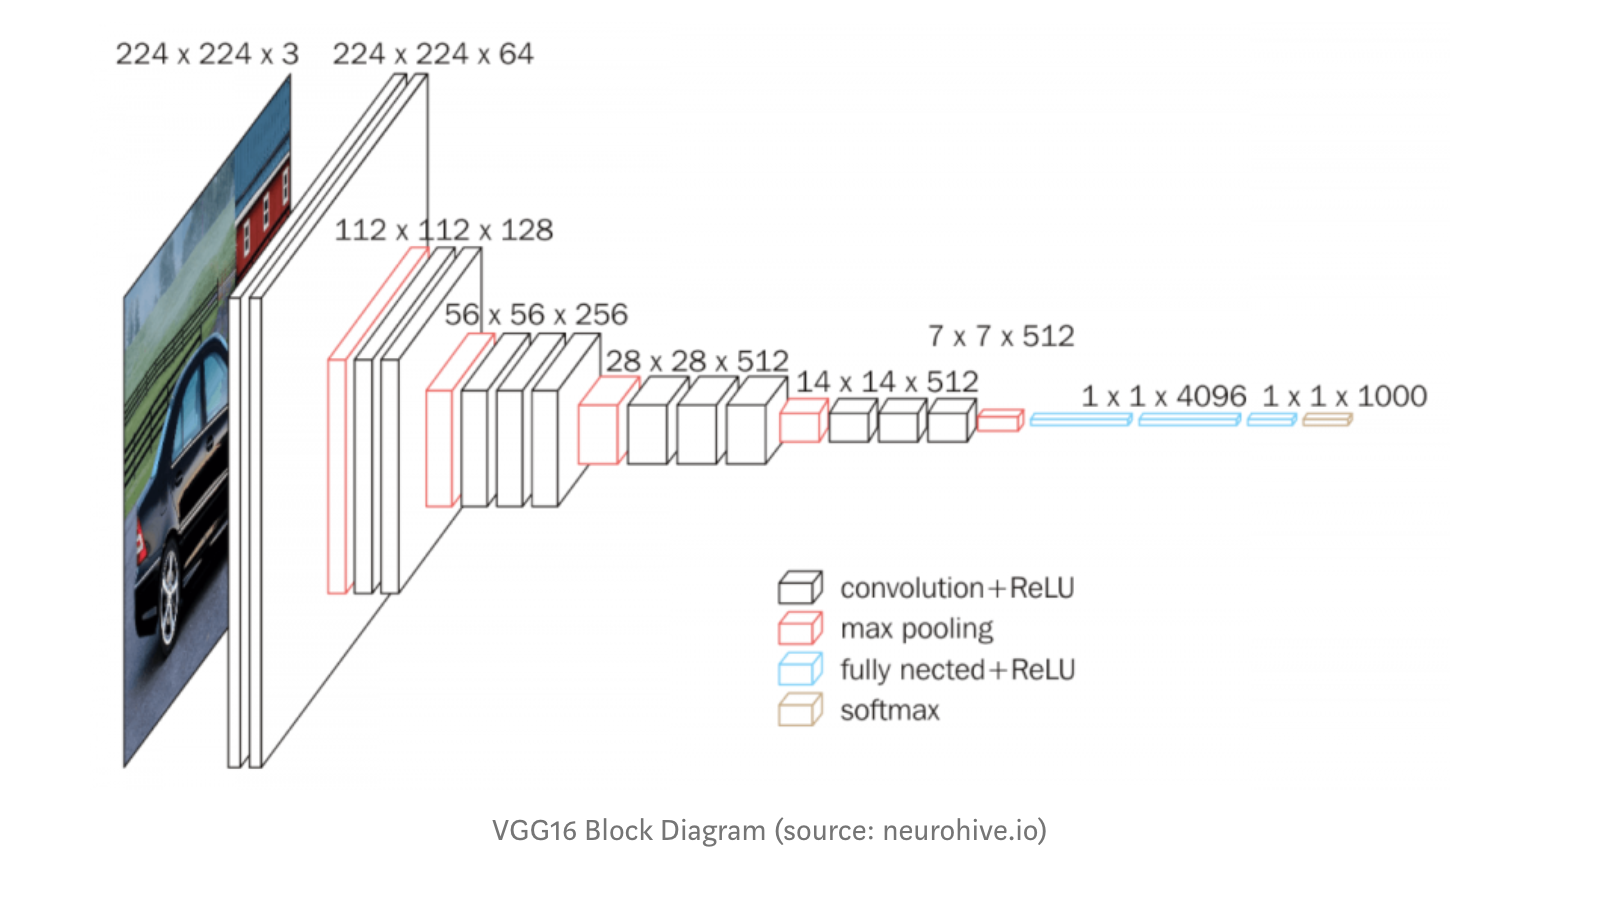

In [1]:
from IPython.display import Image
Image(filename='VGG16.1.png',width=800, height=400)


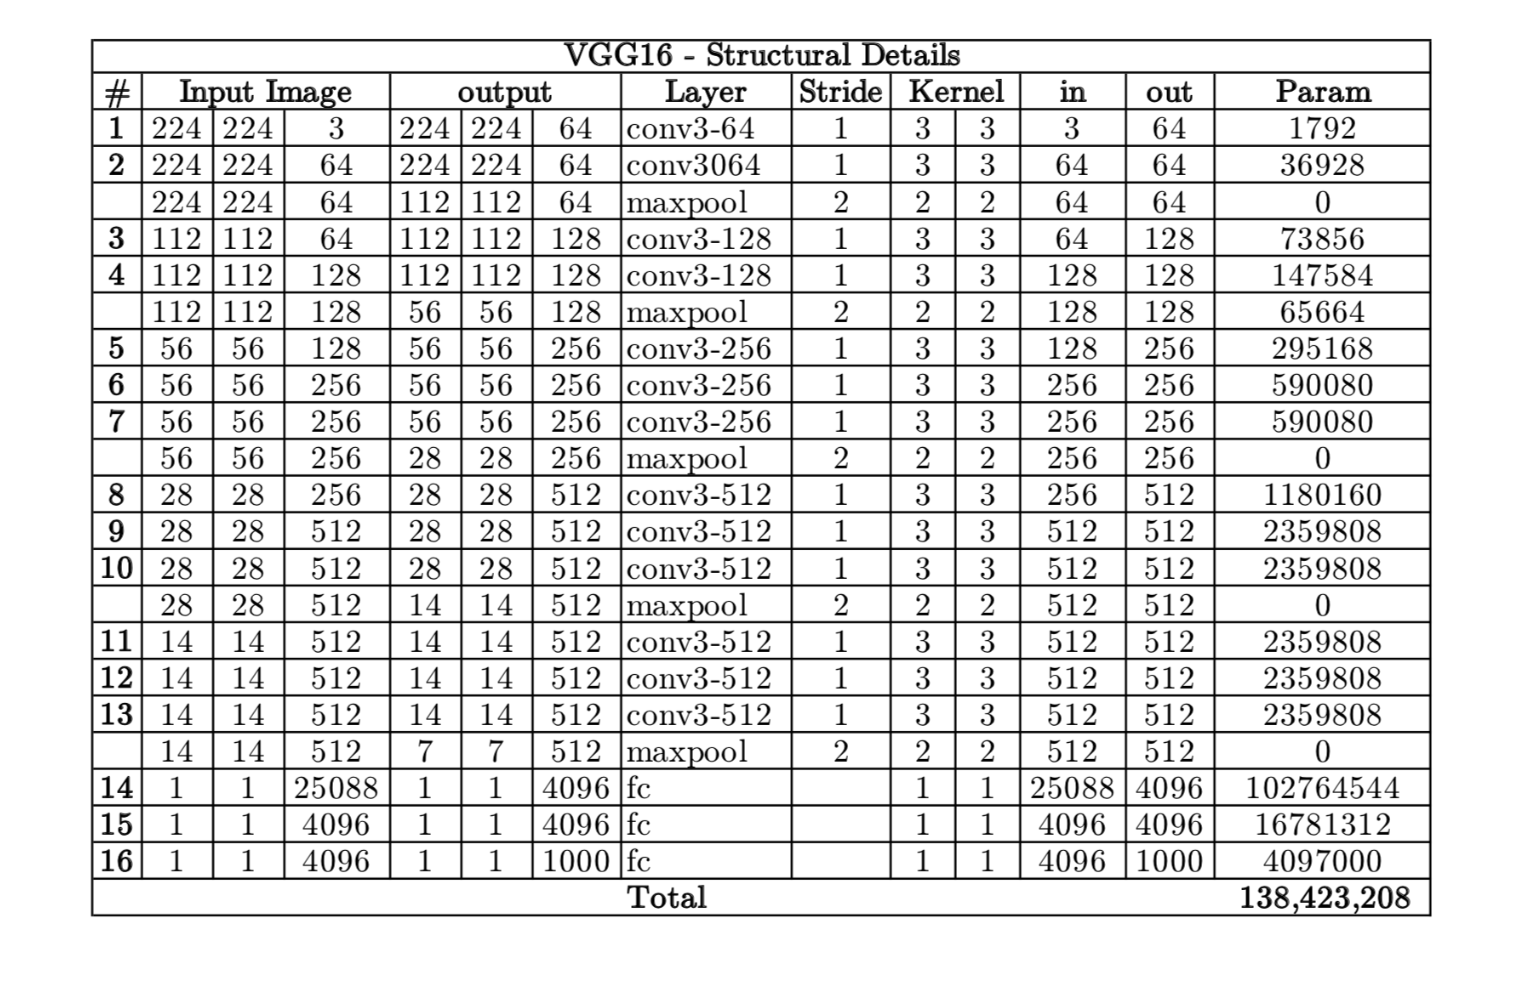

In [2]:
Image(filename='VGG16.2.png',width=800, height=400)

It is noted that the VGGNet model (16?) has ov er 2X the number of parameters as one of the largest ResNet models, with far less top5 accuracy.  

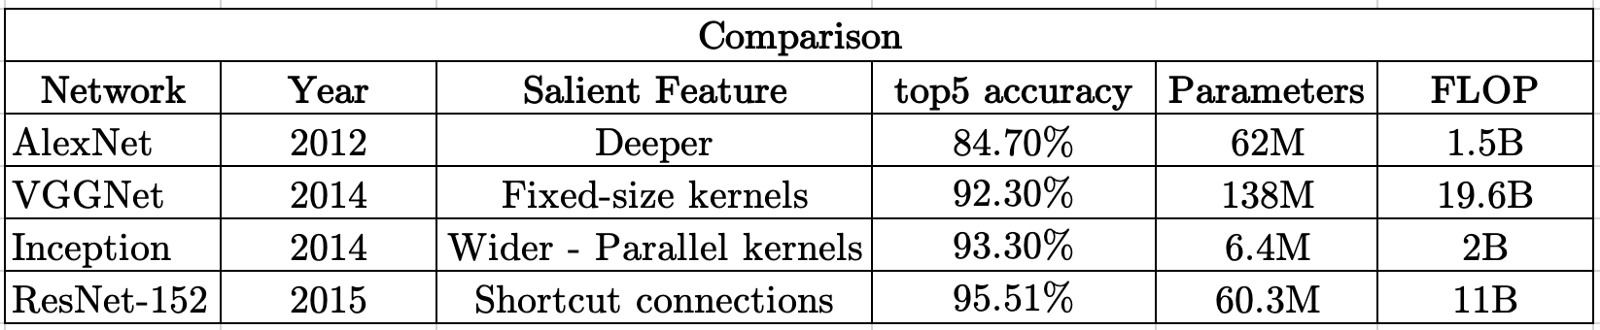

In [3]:
from IPython.display import Image
Image(filename='CV-models.png',width=800, height=400)

## Summary of results


We first compute the Average Alpha $\langle\alpha\rangle$ for all models, and compare to the Test Accuracy accross the models.  In contrast to expectations, and other models like ResNet, on average, $\langle\alpha\rangle$ is increasing with Test Accuracy instead of decreasing.  In fact, $\langle\alpha\rangle$ is strongly *negatively correlated* with reported Test Accuracy.  

#### Why is this ?

If we look at $\alpha$ vs Layer Id, we see that  $\alpha$ is increasing with Layer Id. That is, as information flows thorugh the network, the layers are less and less correlated.  THis suggests (to me) that the VGG networks are fairly bad at funneling information through the network.

Instead, we need to use the Weighted Alpha metric $\hat{\alpha}$ , which is positively correlated with the Test Accuracy.  

## Calculation of Results

In [4]:
# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [5]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Import WeightWatcher

set custom Logging at WARN Level

In [6]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARN)

import weightwatcher as ww
import torchvision.models as models

ww.__version__

Using TensorFlow backend.


'0.2.7'

###  Helper Notebook to make Plots


In [7]:
import import_ipynb
import ModelPlots as MP

importing Jupyter notebook from ModelPlots.ipynb


### Create all models now

Pick colors from https://matplotlib.org/3.1.0/gallery/color/named_colors.html

In [8]:
series_name = 'VGG'
all_names = [ 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']
colors =    ['indigo', 'blue',    'purple',  'cyan',   'darkgreen','goldenrod','darkorange','red']


all_models = []
all_models.append(models.vgg11(pretrained=True))
all_models.append(models.vgg11_bn(pretrained=True))

all_models.append(models.vgg13(pretrained=True))
all_models.append(models.vgg13_bn(pretrained=True))

all_models.append(models.vgg16(pretrained=True))
all_models.append(models.vgg16_bn(pretrained=True))

all_models.append(models.vgg19(pretrained=True))
all_models.append(models.vgg19_bn(pretrained=True))


### Get reported accuracies from pytorch website

https://pytorch.org/docs/stable/torchvision/models.html

<pre>
<table class="docutils align-default">
<colgroup>
<col style="width: 55%" />
<col style="width: 22%" />
<col style="width: 22%" />
</colgroup>
<thead>
<thead>
<tr class="row-odd"><th class="head"><p>Network</p></th>
<th class="head"><p>Top-1 error</p></th>
<th class="head"><p>Top-5 error</p></th>
</tr>
</thead>
<tbody>

<tr class="row-odd"><td><p>VGG-11</p></td>
<td><p>30.98</p></td>
<td><p>11.37</p></td>
</tr>
<tr class="row-even"><td><p>VGG-13</p></td>
<td><p>30.07</p></td>
<td><p>10.75</p></td>
</tr>
<tr class="row-odd"><td><p>VGG-16</p></td>
<td><p>28.41</p></td>
<td><p>9.62</p></td>
</tr>
<tr class="row-even"><td><p>VGG-19</p></td>
<td><p>27.62</p></td>
<td><p>9.12</p></td>
</tr>
<tr class="row-odd"><td><p>VGG-11 with batch normalization</p></td>
<td><p>29.62</p></td>
<td><p>10.19</p></td>
</tr>
<tr class="row-even"><td><p>VGG-13 with batch normalization</p></td>
<td><p>28.45</p></td>
<td><p>9.63</p></td>
</tr>
<tr class="row-odd"><td><p>VGG-16 with batch normalization</p></td>
<td><p>26.63</p></td>
<td><p>8.50</p></td>
</tr>
<tr class="row-even"><td><p>VGG-19 with batch normalization</p></td>
<td><p>25.76</p></td>
<td><p>8.15</p></td>
</tr>
</tbody>
</table>
</pre>

In [9]:
top1_errors= {
    
    "vgg11": 30.98,
    "vgg11_bn": 29.62,
    "vgg13": 30.07,
    "vgg13_bn": 28.45,
    "vgg16": 28.41,
    "vgg16_bn": 26.63,
    "vgg19": 27.62,
    "vgg19_bn": 25.76,
}

In [10]:
top5_errors= {
    
    "vgg11": 11.37,
    "vgg11_bn": 10.19,
    "vgg13": 10.75,
    "vgg13_bn": 9.63,
    "vgg16": 9.62,
    "vgg16_bn": 8.50,
    "vgg19": 9.12,
    "vgg19_bn": 8.15,
}

### Run WeightWatcher, collect summary and details (as dataframes) for all models

In [11]:
all_details = []
all_summaries = []
for im, name in enumerate(tqdm(all_names)):
    watcher = ww.WeightWatcher(model=all_models[im], logger=logger)
    results = watcher.analyze(alphas=True, softranks=True, spectralnorms=True, mp_fit=True,
                             normalize=False, glorot_fix=False)

    summary =  watcher.get_summary()
    all_summaries.append(summary)
    
    details  = watcher.get_details(results=results)
    details.drop(columns=['slice', 'slice_count'], inplace=True)
    details.dropna(inplace=True)
    details['NxM'] = pd.to_numeric(details.N * details.M)

    all_details.append(details)

100%|██████████| 8/8 [41:40<00:00, 312.55s/it]


In [19]:
plt.rcParams.update({'font.size': 20})
from pylab import rcParams
rcParams['figure.figsize'] = 10,10


In [20]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10,10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [21]:
first_n_last_ids = [0, len(all_details)-2]

saving img/VGG_lognorm_accs.png


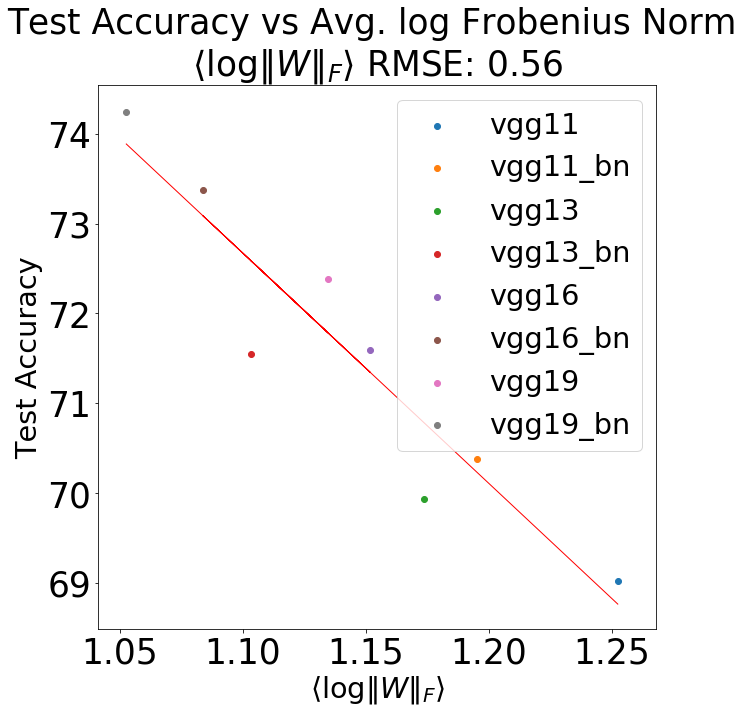

saving img/VGG_alpha_accs.png


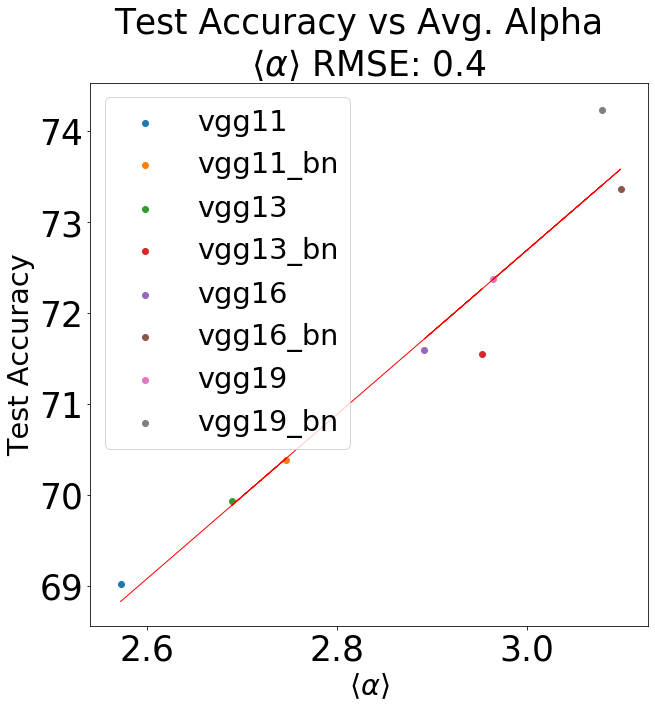

saving img/VGG_alpha_weighted_accs.png


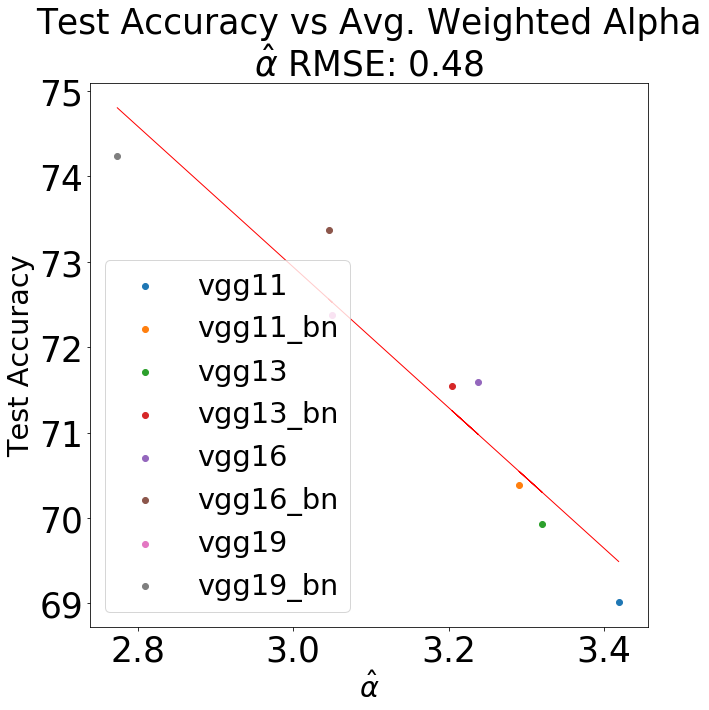

saving img/VGG_spectralnorm_accs.png


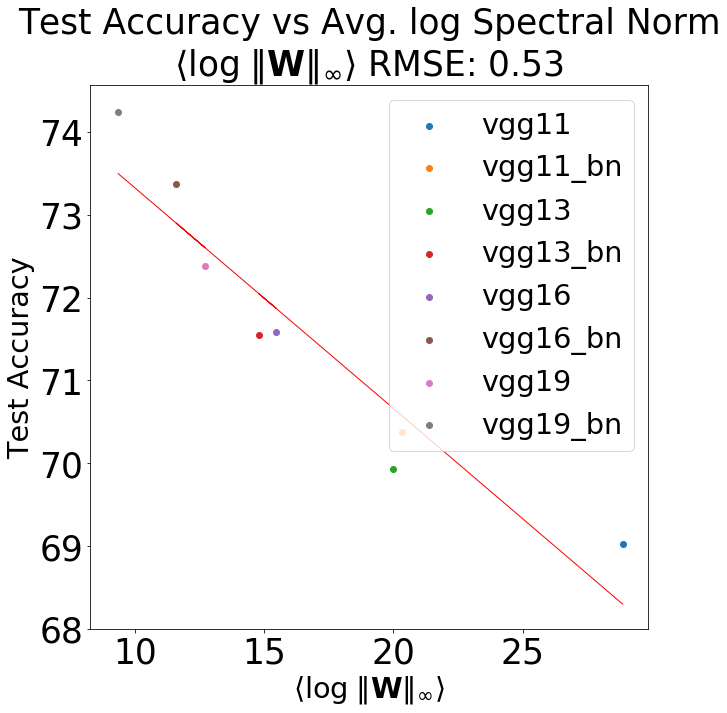

saving img/VGG_softranklog_accs.png


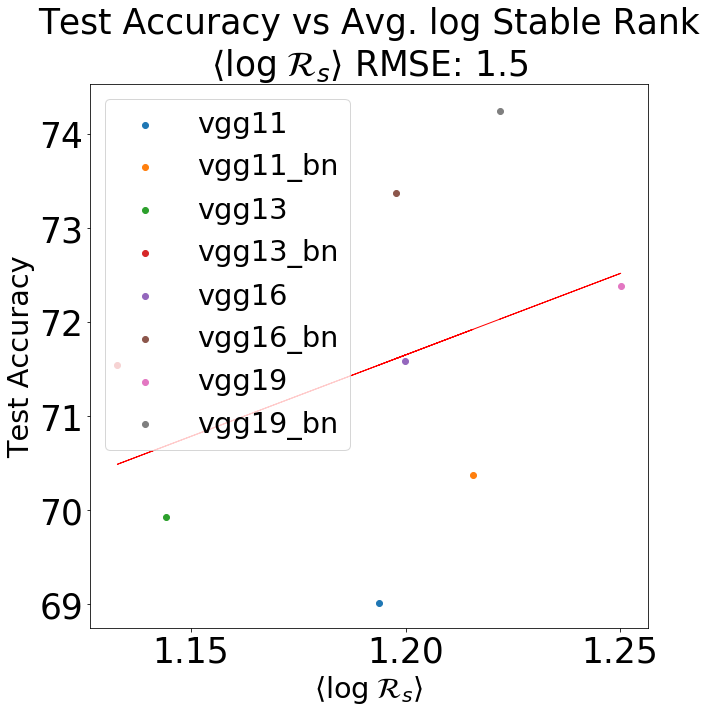

saving img/VGG_softrank_mp_accs.png


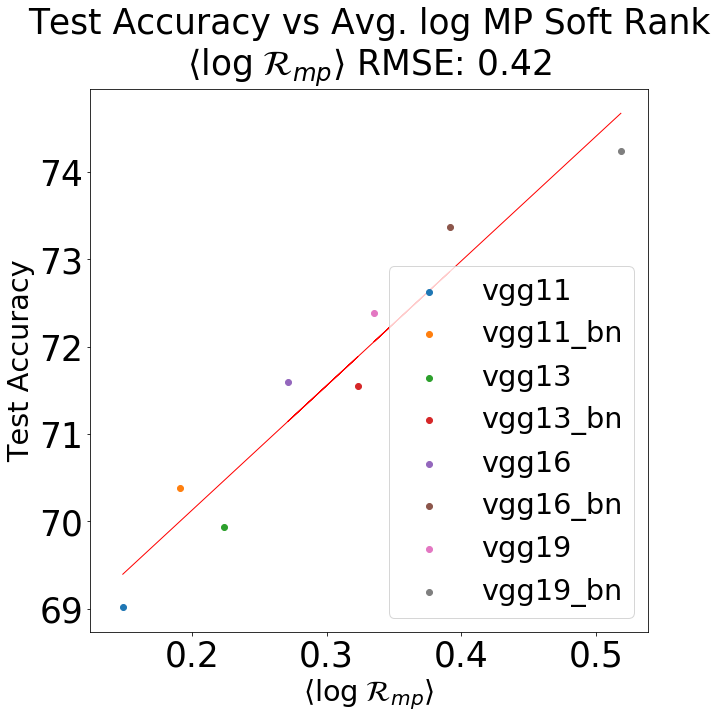

saving img/VGG_logpnorm_accs.png


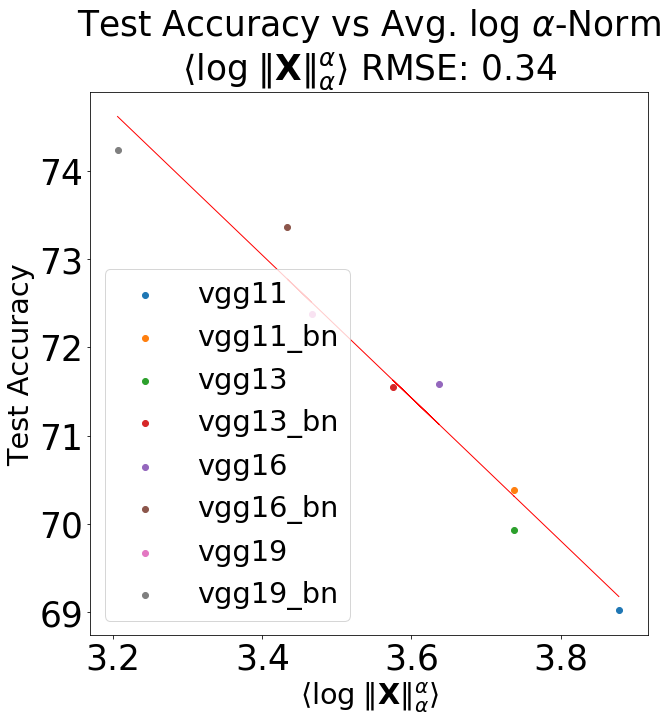

In [22]:
MP.plot_all_metrics_vs_test_accuracies( \
    series_name, all_names, colors, all_summaries, all_details, top1_errors)

saving img/VGG_all_lognorm_hist.png


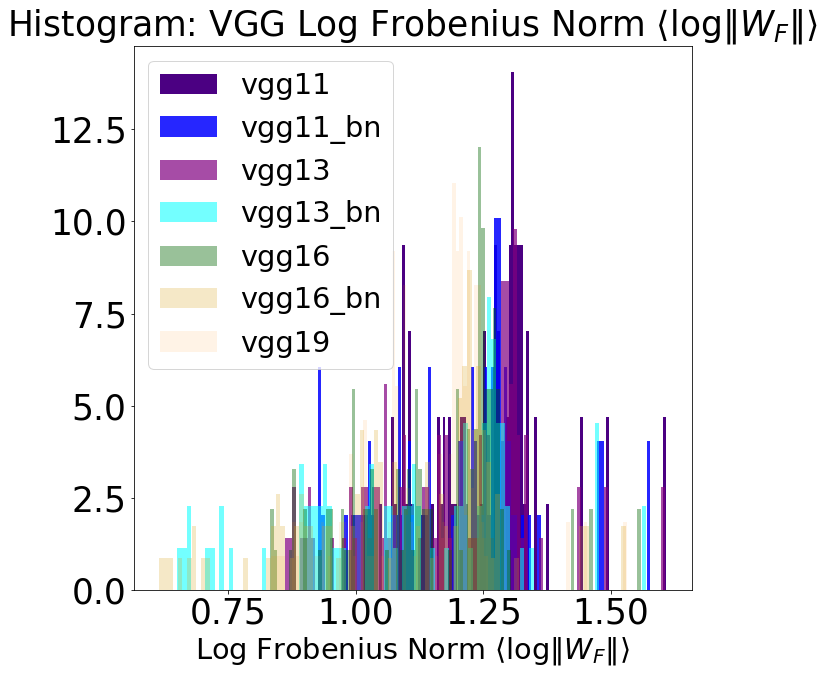

saving img/VGG_fnl_lognorm_hist.png


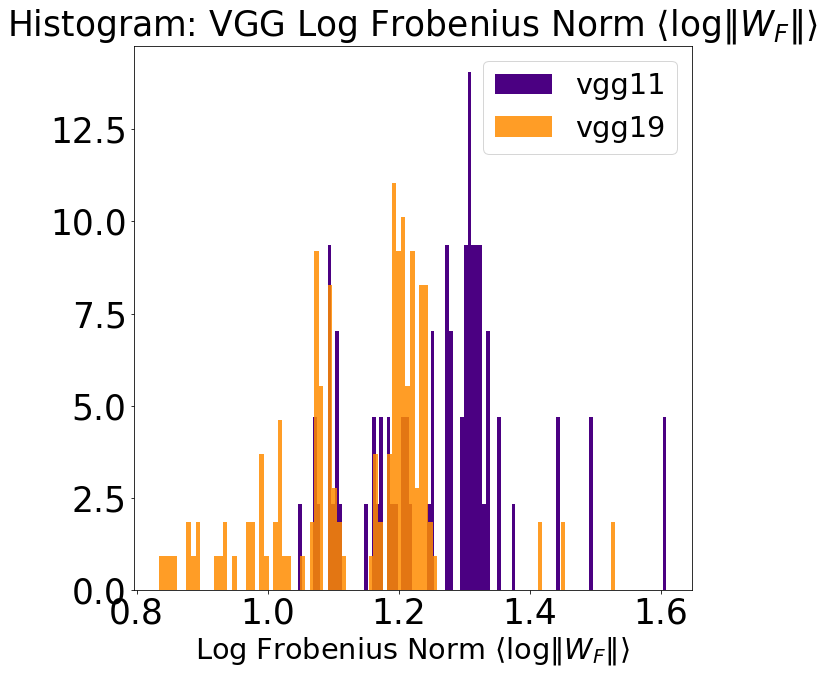

saving img/VGG_all_alpha_hist.png


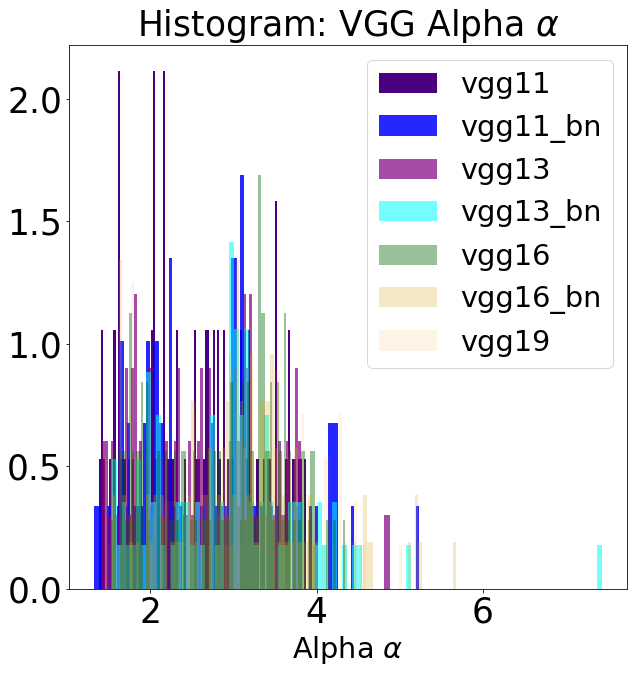

saving img/VGG_fnl_alpha_hist.png


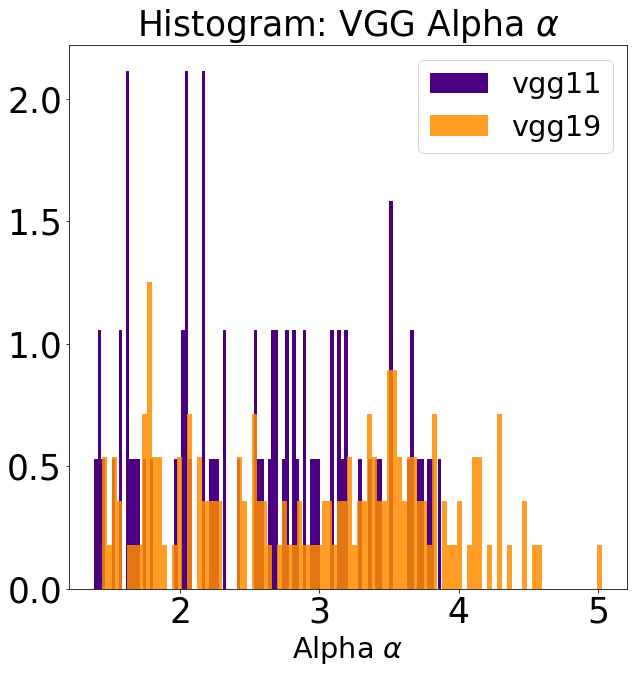

saving img/VGG_all_alpha_weighted_hist.png


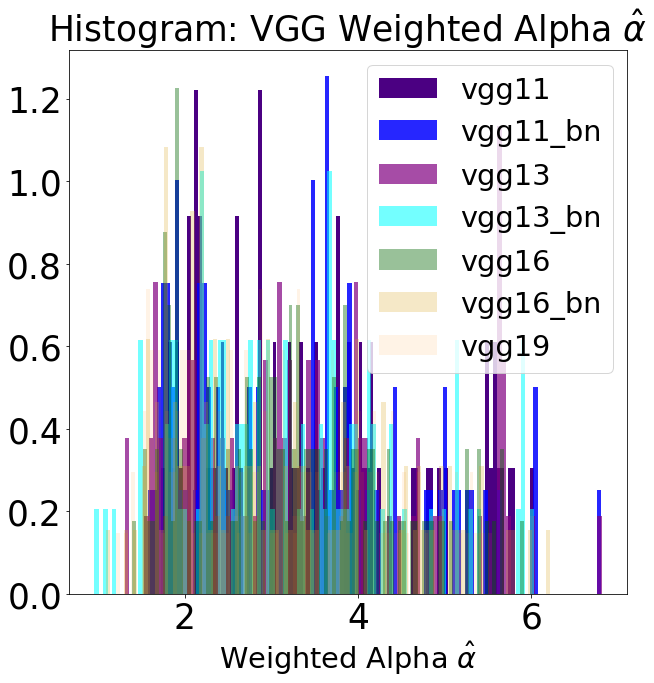

saving img/VGG_fnl_alpha_weighted_hist.png


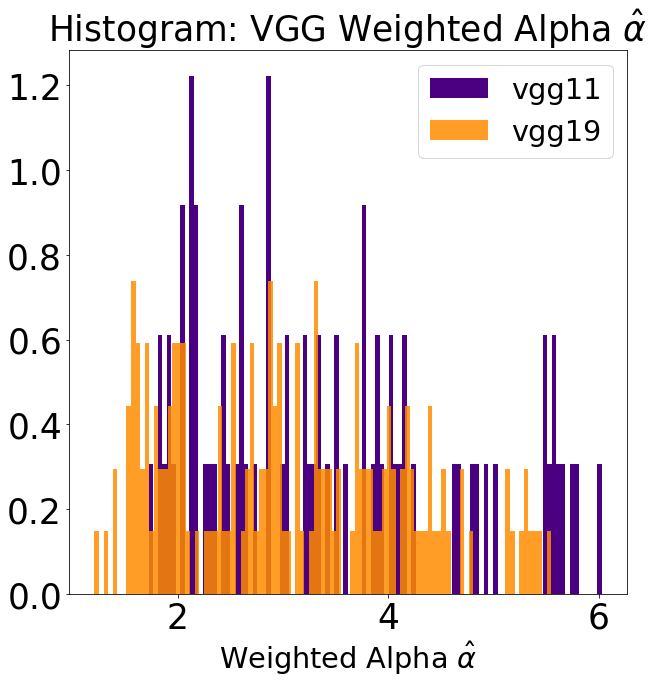

saving img/VGG_all_softranklog_hist.png


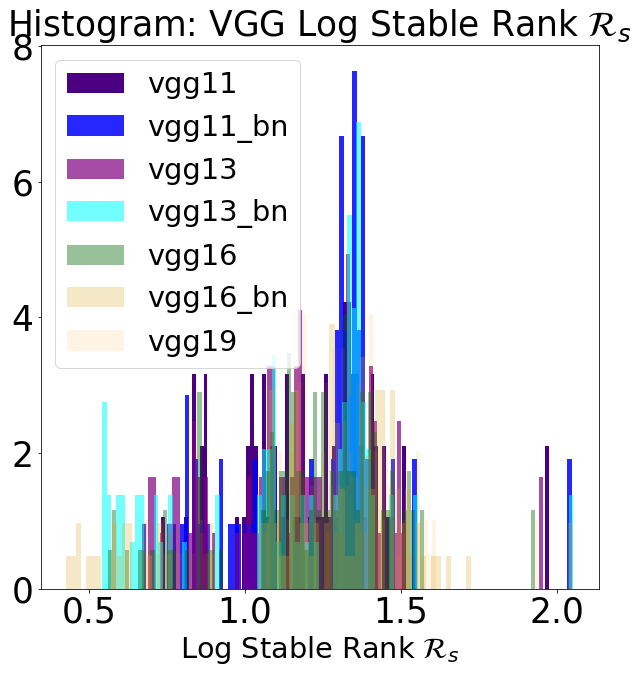

saving img/VGG_fnl_softranklog_hist.png


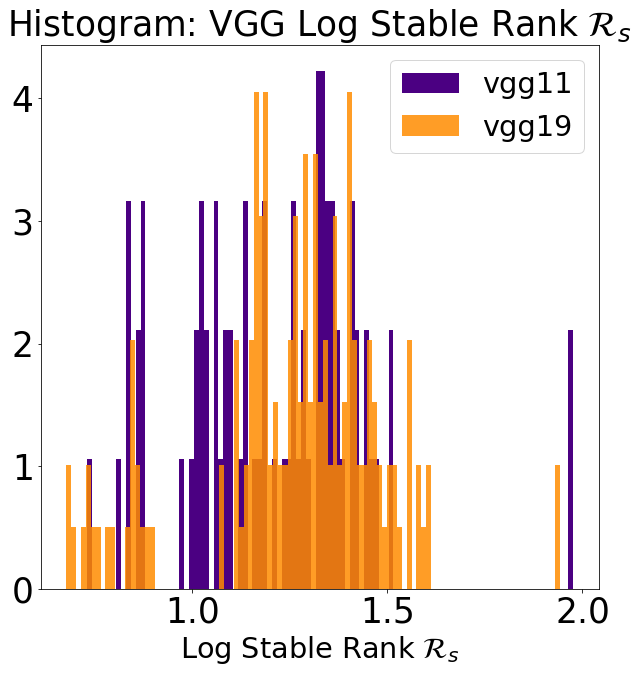

saving img/VGG_all_spectralnorm_hist.png


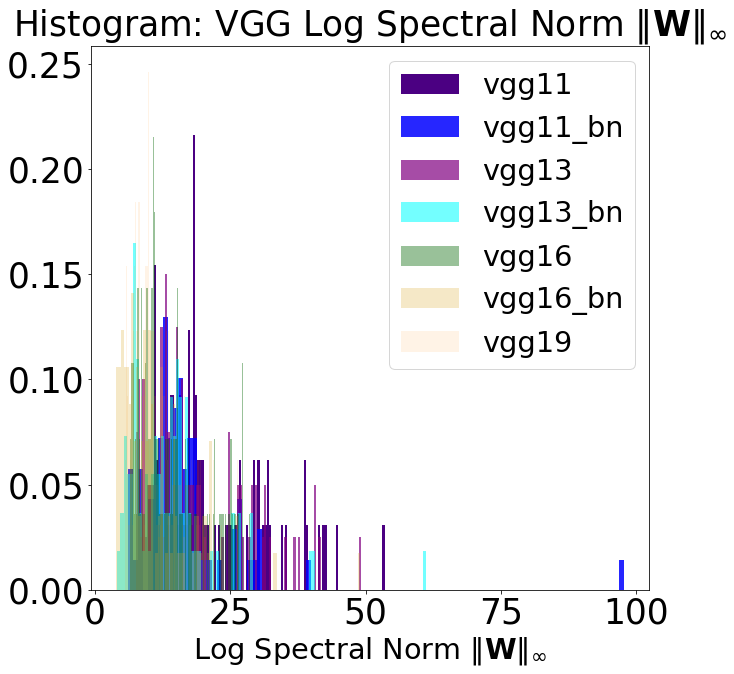

saving img/VGG_fnl_spectralnorm_hist.png


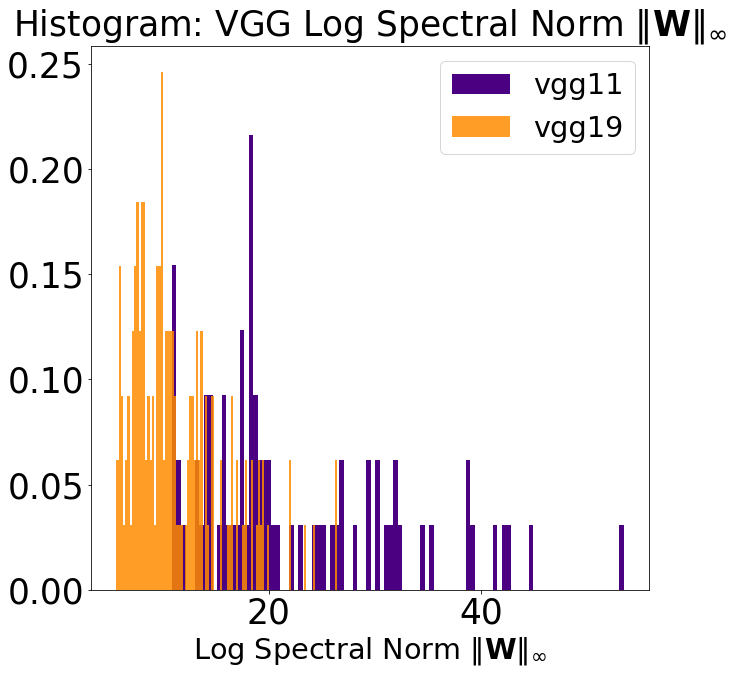

saving img/VGG_all_softrank_mp_hist.png


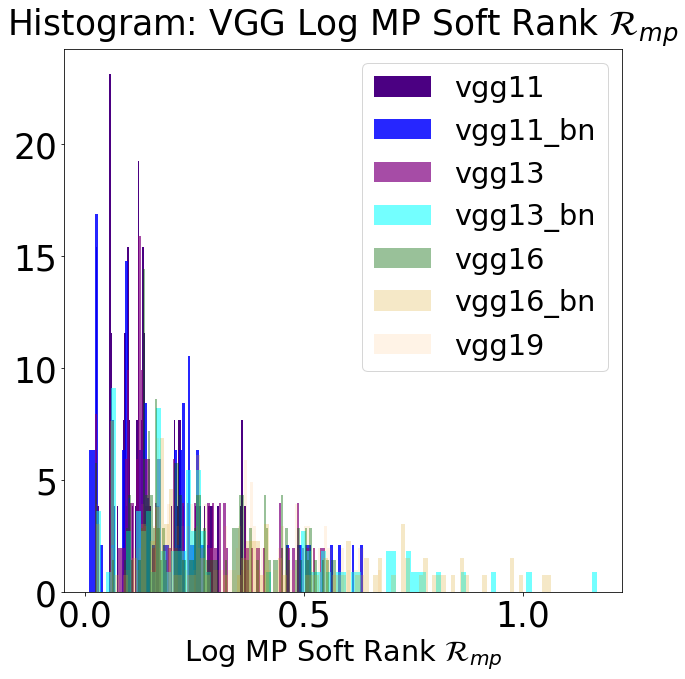

saving img/VGG_fnl_softrank_mp_hist.png


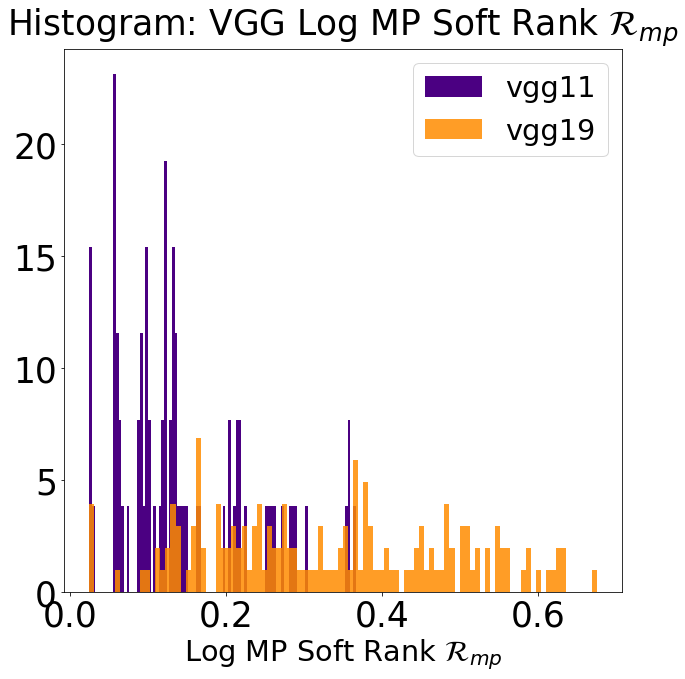

saving img/VGG_all_logpnorm_hist.png


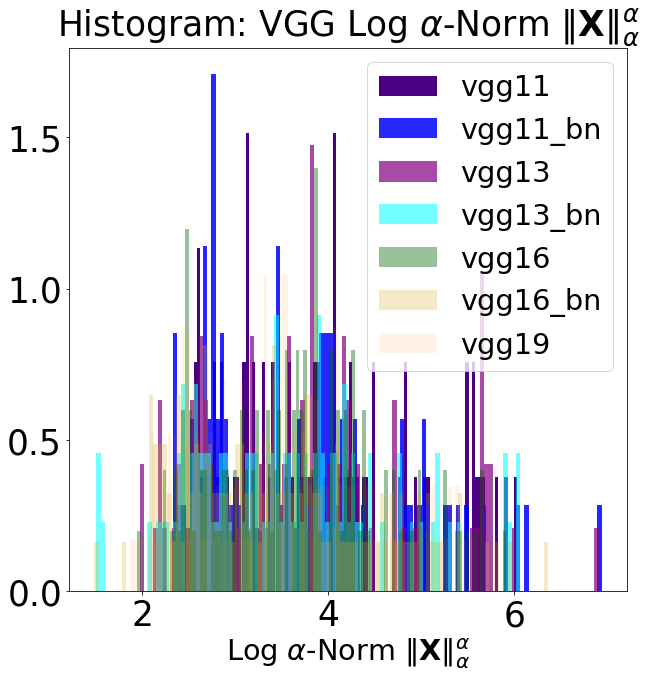

saving img/VGG_fnl_logpnorm_hist.png


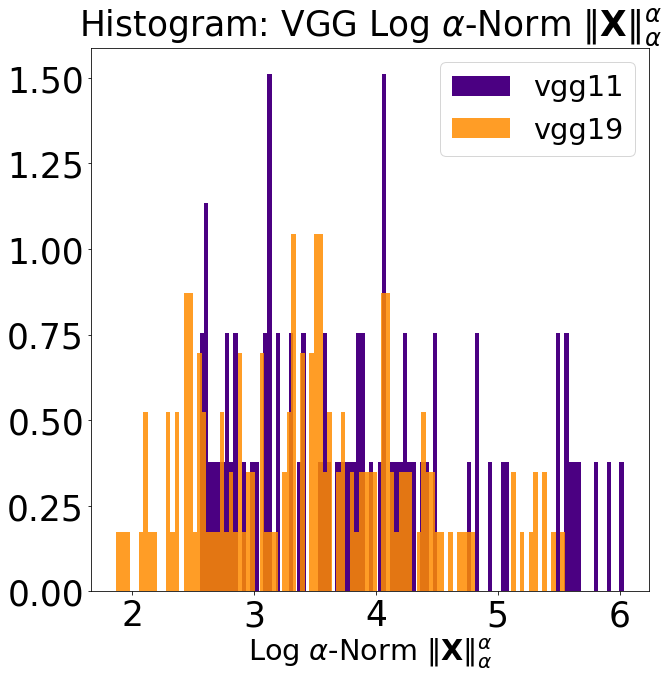

In [23]:
MP.plot_all_metric_histograms( \
    series_name, all_names, colors, all_summaries, all_details, first_n_last_ids)

saving img/VGG_all_lognorm_depth.png


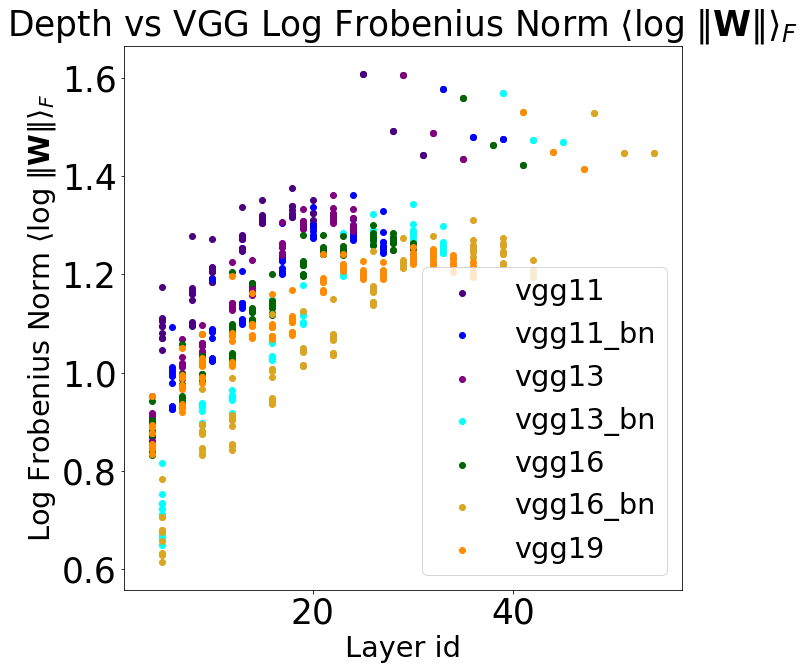

saving img/VGG_fnl_lognorm_depth.png


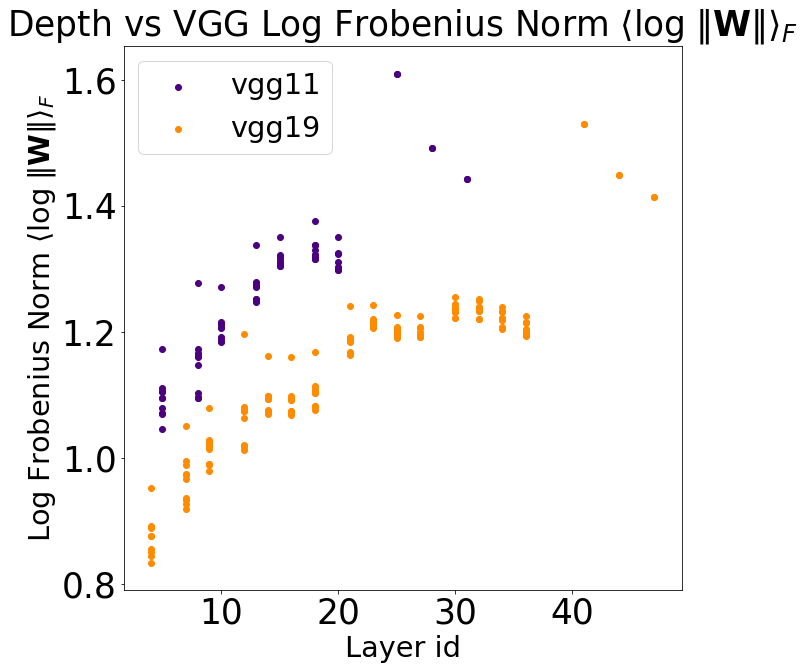

saving img/VGG_all_alpha_depth.png


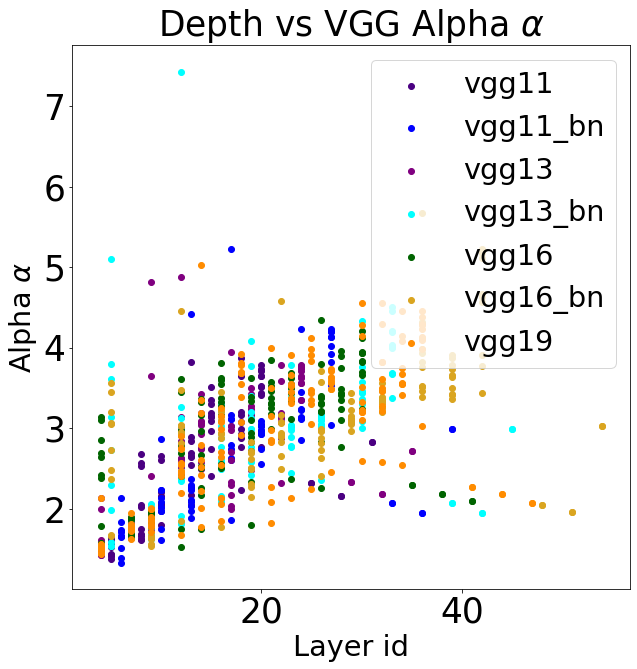

saving img/VGG_fnl_alpha_depth.png


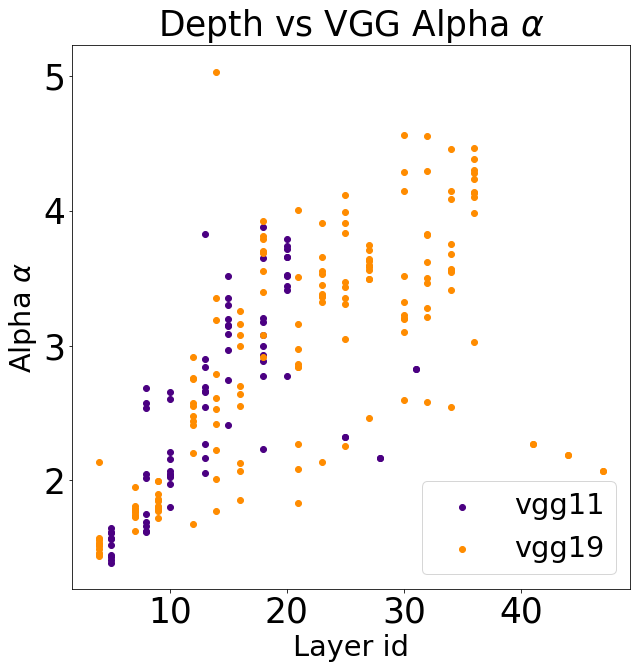

saving img/VGG_all_alpha_weighted_depth.png


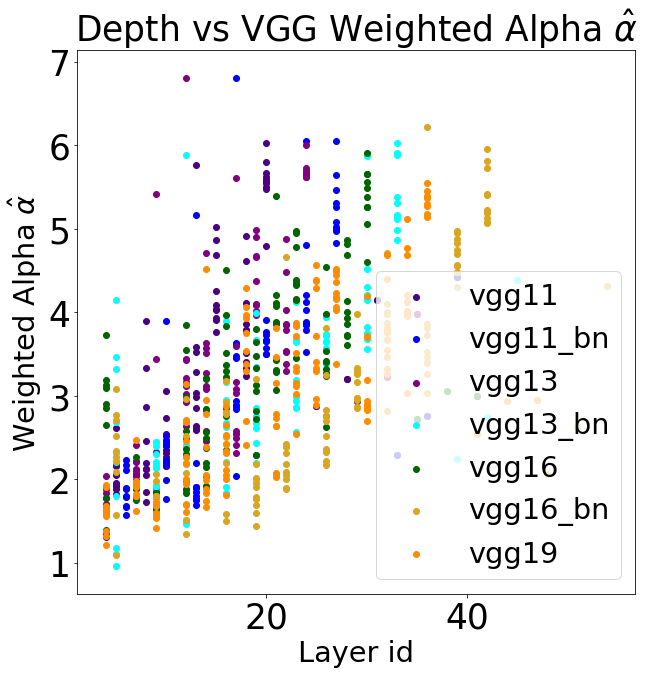

saving img/VGG_fnl_alpha_weighted_depth.png


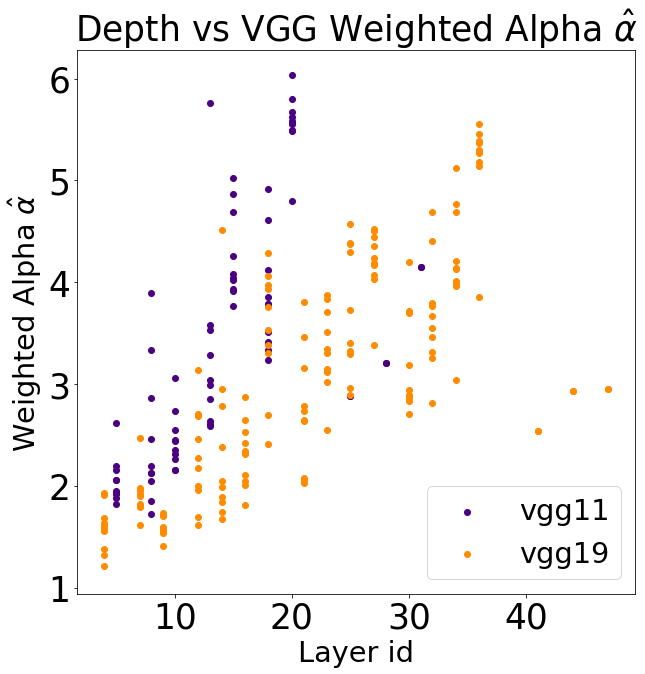

saving img/VGG_all_softranklog_depth.png


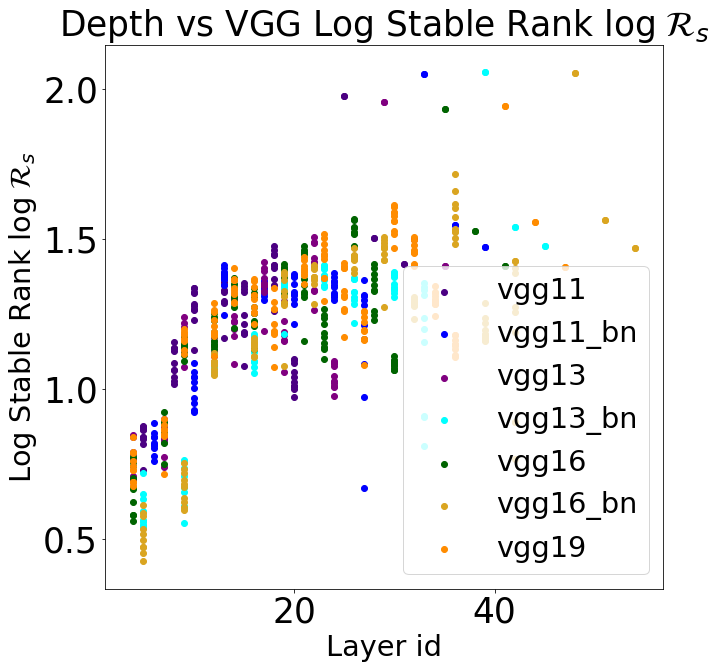

saving img/VGG_fnl_softranklog_depth.png


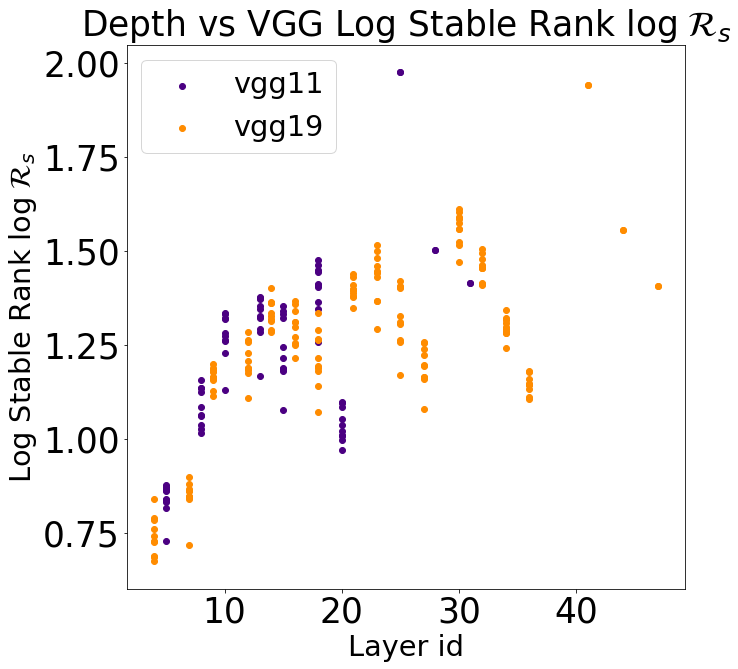

saving img/VGG_all_spectralnorm_depth.png


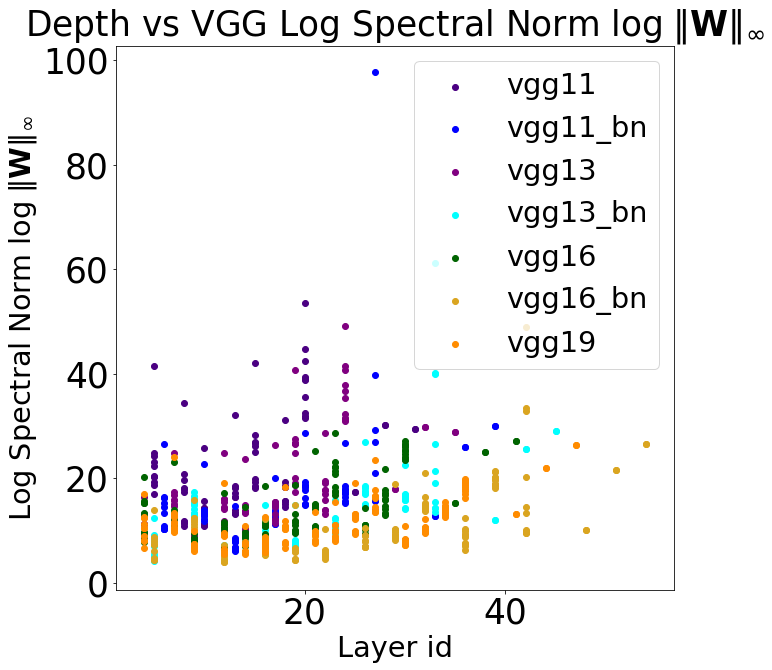

saving img/VGG_fnl_spectralnorm_depth.png


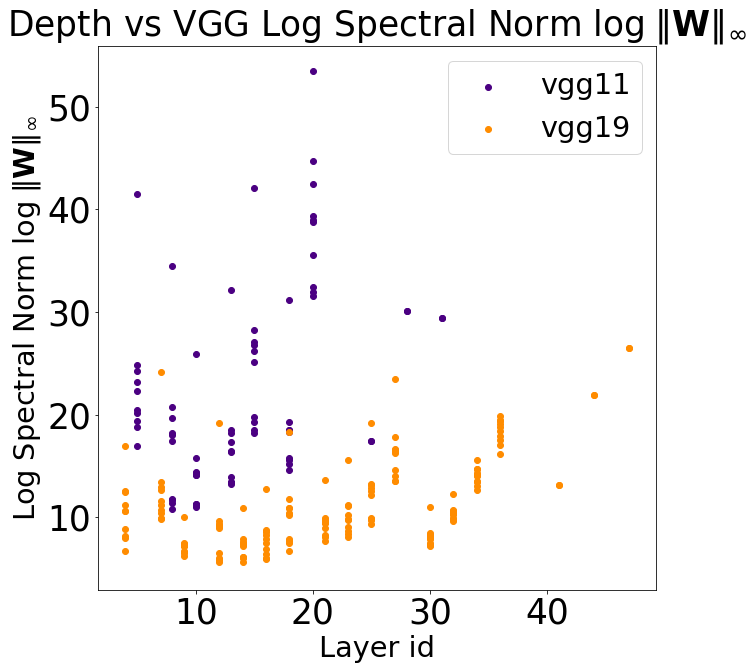

saving img/VGG_all_softrank_mp_depth.png


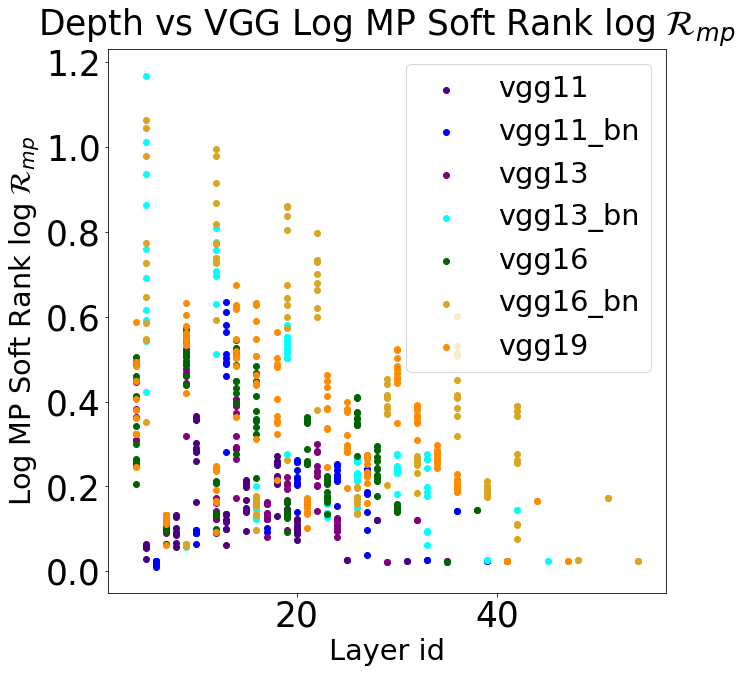

saving img/VGG_fnl_softrank_mp_depth.png


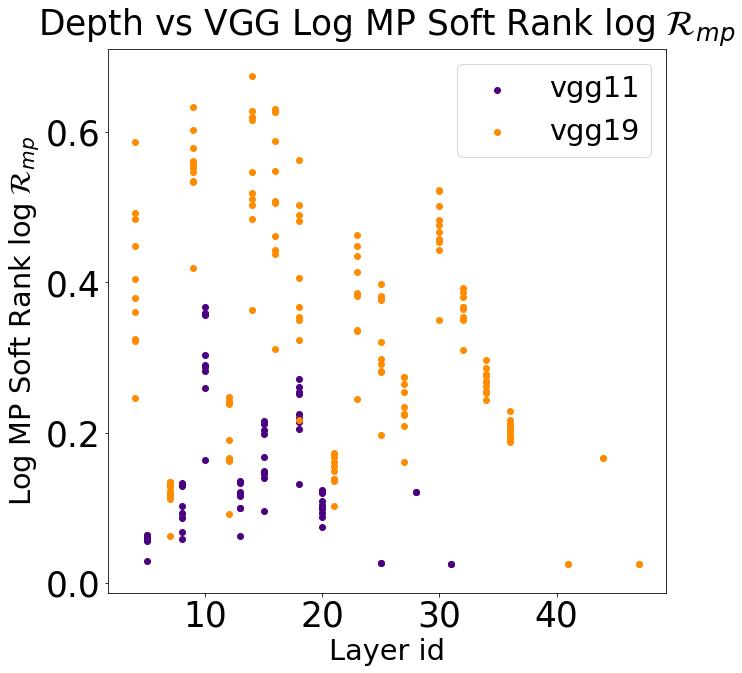

saving img/VGG_all_logpnorm_depth.png


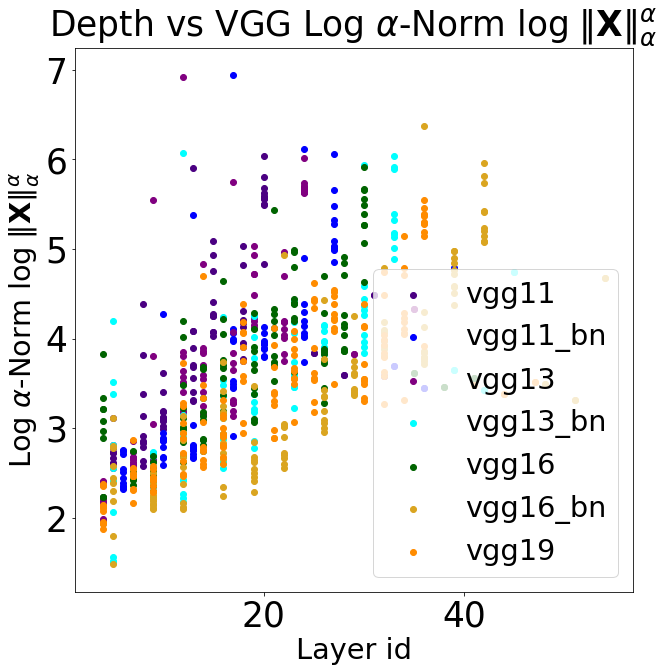

saving img/VGG_fnl_logpnorm_depth.png


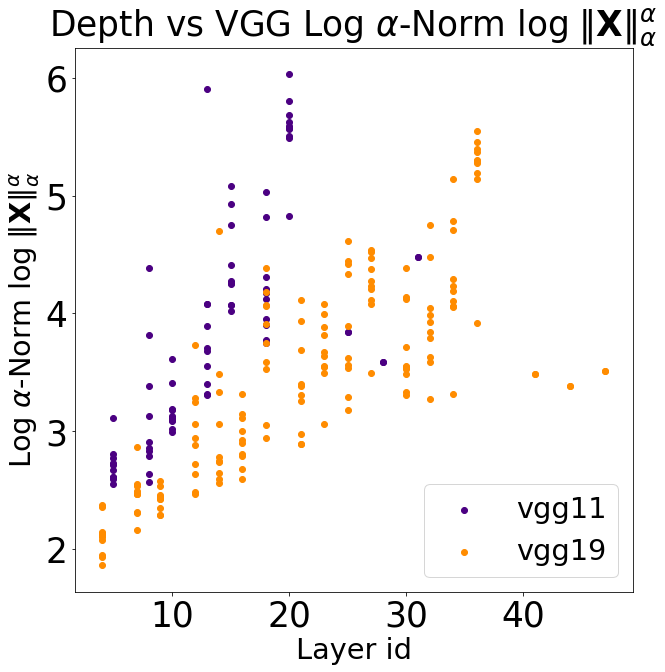

In [24]:
MP.plot_all_metric_vs_depth( \
    series_name, all_names, colors, all_summaries, all_details, first_n_last_ids)


In [25]:
all_details[0]

,layer_type,N,M,level,comment,check,checkTF,norm,lognorm,normX,...,logspectralnorm,softrank,softranklog,softranklogratio,sigma_mp,numofSpikes,ratio_numofSpikes,softrank_mp,logpnorm,NxM
layer_id,,,,,,,,,,,,,,,,,,,,,
5,CONV2D,128,64,LEVEL.SLICE,Slice level,1.79926,False,11.7527,1.07014,37.979,...,1.30567,6.83289,0.834605,1.63921,0.638672,20,0.31746,0.0588039,2.77592,8192
5,CONV2D,128,64,LEVEL.SLICE,Slice level,1.95291,False,12.7564,1.10573,45.0731,...,1.39473,6.5573,0.816725,1.58558,0.692754,19,0.301587,0.0563575,2.80843,8192
5,CONV2D,128,64,LEVEL.SLICE,Slice level,1.84183,False,12.0308,1.08029,39.3708,...,1.28734,7.46867,0.873243,1.67833,0.631934,21,0.333333,0.0600512,2.55312,8192
5,CONV2D,128,64,LEVEL.SLICE,Slice level,1.90441,False,12.4396,1.09481,41.7004,...,1.31185,7.54683,0.877764,1.66911,0.653379,20,0.31746,0.0606744,2.61455,8192
5,CONV2D,128,64,LEVEL.SLICE,Slice level,2.28471,False,14.9237,1.17388,65.6184,...,1.61769,5.37111,0.730064,1.4513,0.640371,24,0.380952,0.0288202,3.11175,8192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,DENSE,25088,4096,LEVEL.LAYER,Layer level,0.00566197,0,40.585,1.60837,63.1625,...,1.24035,94.7071,1.97638,2.59341,0.479395,614,0.149939,0.0260501,3.84164,102760448
28,DENSE,4096,4096,LEVEL.SLICE,Slice level,0.0106973,False,30.9827,1.49112,52.4434,...,1.47913,31.8497,1.50311,2.01621,0.953906,46,0.0112332,0.120764,3.5908,16777216
28,DENSE,4096,4096,LEVEL.LAYER,Layer level,0.0106973,0,30.9827,1.49112,52.4434,...,1.47913,31.8497,1.50311,2.01621,0.953906,46,0.0112332,0.120764,3.5908,16777216
